# Growth Mechanism with Details

In [9]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
sys.path.append('../../src')

from m3_learning.RHEED.Dataset import RHEED_parameter_dataset, RHEED_spot_Dataset
from m3_learning.RHEED.Analysis_umich import fit_curves, analyze_rheed_data, select_range, plot_activation_energy
from m3_learning.RHEED.Fitter1D import Model, Multiscale1DFitter
from m3_learning.be.nn import SHO_fit_func_nn, SHO_Model

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


<__array_function__ internals>:180: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
../../src\m3_learning\RHEED\Analysis_umich.py:59: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys_nor_all = np.array(ys_nor_all)
../../src\m3_learning\RHEED\Analysis_umich.py:60: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ys_nor_fit_all = np.array(ys

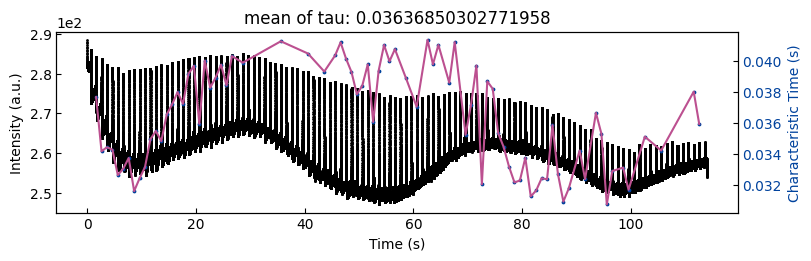

In [7]:
para_path = './Datasets/J14_PM04_05_06_gaussian_fit_parameters_08252023.h5'
ds_para = RHEED_parameter_dataset(para_path, camera_freq=2000, sample_name='J14')
ds_para.dataset_names
# denoise_params = {'savgol_window_order': (51,3), 'pca_component': 3, 'fft_cutoff_order':(20, 1), 'median_kernel_size':51}
denoise_params = {'savgol_window_order': (51, 3), 'pca_component': None, 'fft_cutoff_order':(5, 1), 'median_kernel_size':51}
curve_params = {'trim_first':0, 'tune_tail':True, 'convolve_step':15, 'prominence':0.2, 'mode':'full', 'linear_ratio':0.8}
normalize_params = {'I_diff': None, 'unify':True, 'bounds':[0.01, 1], 'p_init':(1, 0.1, 0.4), 'n_std':1}
viz_params = {'viz_denoise': False, 'viz_curves': False, 'viz_fittings': False, 'viz_ab': False}
    
laser_freq = 1
camera_freq = 2000

sample_x, sample_y = ds_para.load_curve(growth='temp250', spot='spot_2', metric='img_rec_max', x_start=0)
data = np.stack([sample_x, sample_y], 1)
data = select_range(data, *(0, 114))

parameters_all, x_list_all, info, tau = analyze_rheed_data(data, camera_freq, laser_freq, denoise_params, curve_params, normalize_params, viz_params)
[xs_all, ys_all, ys_fit_all, ys_nor_all, ys_nor_fit_all, ys_nor_fit_failed_all, labels_all, losses_all] = info

In [8]:
mean_length = np.mean([len(y) for y in ys_all])
mean_length = int(mean_length)
mean_length
ys_all_same_length = []
for y in ys_all:
    ys_all_same_length.append(np.interp(np.linspace(0, 1, mean_length), np.linspace(0, 1, len(y)), y))
ys_all_same_length = np.array(ys_all_same_length)
ys_all_same_length.shape

(113, 1987)

In [21]:
import torch

func = SHO_fit_func_nn
# model_ = Multiscale1DFitter(SHO_fit_func_nn, # function 
#                             dataset.frequency_bin, # x data
#                             2, # input channels
#                             4, # output channels
#                             dataset.SHO_scaler, 
#                             postprocessor)

# instantiate the model
# model = Model(model_, dataset, training=True, model_basename="SHO_Fitter_original_data")
model_ = Multiscale1DFitter(SHO_fit_func_nn, # function 
                            ys_all_same_length, # x data
                            1, # input channels
                            4, # output channels
                            device=torch.device('cpu'))
model_

Multiscale1DFitter(
  (hidden_x1): Sequential(
    (0): Conv1d(1, 8, kernel_size=(7,), stride=(1,))
    (1): SELU()
    (2): Conv1d(8, 6, kernel_size=(7,), stride=(1,))
    (3): SELU()
    (4): Conv1d(6, 4, kernel_size=(5,), stride=(1,))
    (5): SELU()
    (6): AdaptiveAvgPool1d(output_size=64)
  )
  (hidden_xfc): Sequential(
    (0): Linear(in_features=256, out_features=20, bias=True)
    (1): SELU()
    (2): Linear(in_features=20, out_features=20, bias=True)
    (3): SELU()
  )
  (hidden_x2): Sequential(
    (0): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (1): Conv1d(2, 4, kernel_size=(5,), stride=(1,))
    (2): SELU()
    (3): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (4): SELU()
    (5): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (6): SELU()
    (7): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (8): SELU()
    (9): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
    (10): SELU()
    (11): Conv1d(4, 4, kernel_size=(5,), stride=(1,))
   

In [22]:
data = torch.tensor(ys_all_same_length).float()
data = data.unsqueeze(2)
data.shape

torch.Size([113, 1987, 1])

In [23]:
out, unscaled_param = model_(data)
out.shape, unscaled_param.shape

(torch.Size([113, 1987]), torch.Size([113, 4]))

In [24]:
unscaled_param

tensor([[-0.0938, -0.5252,  0.3490, -0.2866],
        [-0.0930, -0.5319,  0.3456, -0.2928],
        [-0.0950, -0.5394,  0.3439, -0.2992],
        [-0.0975, -0.5479,  0.3424, -0.3061],
        [-0.1023, -0.5557,  0.3426, -0.3127],
        [-0.1015, -0.5641,  0.3387, -0.3204],
        [-0.1035, -0.5664,  0.3387, -0.3231],
        [-0.1039, -0.5689,  0.3382, -0.3245],
        [-0.1050, -0.5752,  0.3363, -0.3301],
        [-0.1033, -0.5707,  0.3369, -0.3264],
        [-0.1051, -0.5792,  0.3349, -0.3347],
        [-0.1074, -0.5840,  0.3343, -0.3383],
        [-0.1066, -0.5815,  0.3346, -0.3368],
        [-0.1066, -0.5872,  0.3329, -0.3416],
        [-0.1064, -0.5830,  0.3341, -0.3382],
        [-0.1064, -0.5830,  0.3343, -0.3373],
        [-0.1058, -0.5822,  0.3340, -0.3373],
        [-0.1079, -0.5835,  0.3349, -0.3380],
        [-0.1098, -0.6047,  0.3268, -0.3586],
        [-0.1094, -0.5920,  0.3321, -0.3469],
        [-0.1093, -0.5965,  0.3306, -0.3507],
        [-0.1090, -0.5960,  0.3302

In [ ]:

# instantiate the model
model = Model(model_, ys_all_same_length, training=True, model_basename="SHO_Fitter_original_data")

In [ ]:
model = Multiscale1DFitter()